In [ ]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as L
import seaborn as sns
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelSummary, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

import hephaestus.single_row_models as sr

os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Load and preprocess the train_dataset (assuming you have a CSV file)
df = pd.read_csv("./data/diamonds.csv")
df = df.rename(columns={"price": "target"})
# scale the non-target numerical columns
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[float, int]).columns
numeric_cols = numeric_cols.drop("target")
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

,carat,cut,color,clarity,depth,table,target,x,y,z
0,-1.198168,Ideal,E,SI2,-0.174092,-1.099672,326,-1.587837,-1.536196,-1.571129
1,-1.240361,Premium,E,SI1,-1.360738,1.585529,326,-1.641325,-1.658774,-1.741175
2,-1.198168,Good,E,VS1,-3.385019,3.375663,327,-1.498691,-1.457395,-1.741175
3,-1.071587,Premium,I,VS2,0.454133,0.242928,334,-1.364971,-1.317305,-1.287720
4,-1.029394,Good,J,SI2,1.082358,0.242928,335,-1.240167,-1.212238,-1.117674


In [2]:
single_row_config = sr.SingleRowConfig.generate(df, "target")
train_df, test_df = train_test_split(df.copy(), test_size=0.2, random_state=42)
train_dataset = sr.TabularDS(train_df, single_row_config)
test_dataset = sr.TabularDS(test_df, single_row_config)
model = sr.TabularRegressor(single_row_config, d_model=64, n_heads=4, lr=0.01)
model.predict_step(train_dataset[0:10])

tensor([[0.0911],
        [0.1057],
        [0.1083],
        [0.1001],
        [0.1045],
        [0.1301],
        [0.1137],
        [0.1408],
        [0.1117],
        [0.1277]])

In [3]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1024 * 4,
    shuffle=True,
    collate_fn=sr.training.tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1024 * 4,
    collate_fn=sr.training.tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)

In [4]:
logger_variant_name = "ScaleNumericLightningSmall"
logger_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
logger_name = f"{logger_time}_{logger_variant_name}"
print(f"Using logger name: {logger_name}")
logger = TensorBoardLogger(
    "runs",
    name=logger_name,
)
model_summary = ModelSummary(max_depth=3)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")
progress_bar = TQDMProgressBar(leave=False)
trainer = L.Trainer(
    max_epochs=200,
    logger=logger,
    callbacks=[early_stopping, progress_bar, model_summary],
    log_every_n_steps=1,
)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using logger name: 2025-03-22T11:56:03_ScaleNumericLightningSmall



   | Name                                       | Type                    | Params | Mode  | In sizes                             | Out sizes 
----------------------------------------------------------------------------------------------------------------------------------------------------
0  | model                                      | TabularEncoderRegressor | 148 K  | train | [[3, 6], [3, 3]]                     | [3, 1]    
1  | model.tabular_encoder                      | TabularEncoder          | 136 K  | train | [[3, 6], [3, 3]]                     | [3, 9, 64]
2  | model.tabular_encoder.embeddings           | Embedding               | 2.2 K  | train | [3, 9]                               | [3, 9, 64]
3  | model.tabular_encoder.transformer_encoder1 | TransformerEncoderLayer | 33.5 K | train | [[3, 9, 64], [3, 9, 64], [3, 9, 64]] | [3, 9, 64]
4  | model.tabular_encoder.transformer_encoder2 | TransformerEncoderLayer | 33.5 K | train | [[3, 9, 64], [3, 9, 64], [3, 9, 64]] | [3,

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [5]:
y_hat = model.predict_step(train_dataset[0:64])
y = train_dataset[0:64].target
print(y.shape, y_hat.shape)
print(mean_squared_error(y, y_hat))

torch.Size([64]) torch.Size([64, 1])
353489.37411442754


In [8]:
y_hat

tensor([[14952.9521],
        [ 4608.9531],
        [ 5957.5049],
        [ 7814.2920],
        [13340.9004],
        [ 2244.0146],
        [  947.7506],
        [ 1696.5659],
        [ 7556.1299],
        [ 2578.1514],
        [  951.3880],
        [ 4601.4902],
        [ 5331.0776],
        [ 5860.2295],
        [ 1296.4868],
        [ 1988.8207],
        [14044.8398],
        [12767.3174],
        [  961.0662],
        [ 3244.7590],
        [  683.2087],
        [ 1580.0354],
        [ 3858.8843],
        [ 3132.7278],
        [ 1822.1963],
        [ 1805.7627],
        [ 8922.1504],
        [13926.7422],
        [ 1975.9358],
        [  785.4113],
        [ 2088.7239],
        [  853.6226],
        [ 3326.0784],
        [16518.4062],
        [ 4328.3223],
        [ 7172.1646],
        [ 1051.1475],
        [  745.2148],
        [ 3831.9912],
        [ 1408.4487],
        [  801.3079],
        [ 9867.6553],
        [ 2095.1406],
        [ 1131.1458],
        [ 1473.1831],
        [ 

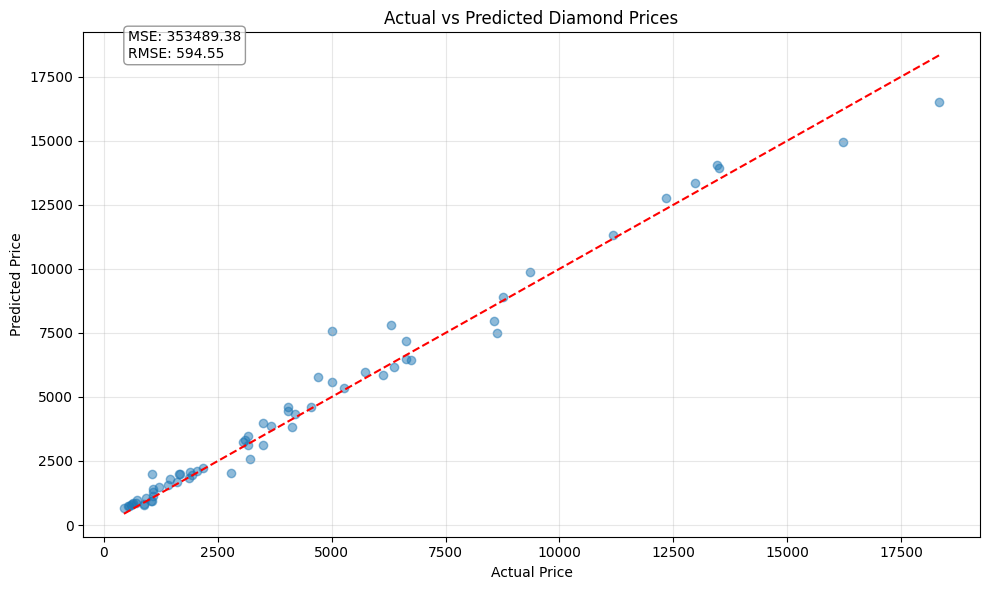

In [ ]:
# Create a scatter plot to compare predicted vs actual values

plt.figure(figsize=(10, 6))
plt.scatter(y.numpy(), y_hat.squeeze().numpy(), alpha=0.5)
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    "r--",
)  # Diagonal line for perfect predictions
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Diamond Prices")
plt.grid(True, alpha=0.3)

# Add some metrics to the plot
mse = mean_squared_error(y.numpy(), y_hat.squeeze().numpy())
rmse = np.sqrt(mse)
plt.annotate(
    f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
)

plt.tight_layout()
plt.show()

In [7]:
1 / 0  # Stop here to avoid running the rest of the code

ZeroDivisionError: division by zero

In [ ]:
model = sr.TabTransformer(train_dataset, n_heads=8).to(train_dataset.device)

batch_size = 3
test_num = train_dataset.X_train_numeric[0:batch_size, :]
test_num_mask = sr.mask_tensor(test_num, model)
test_cat = train_dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = sr.mask_tensor(test_cat, model)
with torch.no_grad():
    x = model(
        test_num_mask,
        test_cat_mask,
        task="mlm",
    )
x[0].shape, x[1].shape

In [ ]:
# Masked Tabular Modeling
base_model_name = "is_model_global2"

model_time = dt.now()
model_time = model_time.strftime("%Y-%m-%dT%H:%M:%S")
model_name = f"{base_model_name}_{model_time}"

model_save_path = "./checkpoints/mtm_models_small.pt"

In [ ]:
model_list = os.listdir("./checkpoints")
if model_save_path.split("/")[-1] in model_list:
    print("Model already exists")
    model_exists = True
else:
    print("Model does not exist")
    model_exists = False

if model_exists:
    model.load_state_dict(torch.load(model_save_path))
else:
    sr.mtm(model, train_dataset, model_name, epochs=100, batch_size=1000, lr=0.001)
    torch.save(model.state_dict(), model_save_path)

In [ ]:
# regression_performance = sr.fine_tune_model(
#     model, train_dataset, model_name="FT100", n_rows=100, epochs=100
# )
# regression_performance

In [ ]:
n_train_rows = [
    # 10,
    100,
    1_000,
    2_000,
    5_000,
    10_000,
    15_000,
    30_000,
    # 40_000,
    train_dataset.X_train.shape[0],
]

In [ ]:
def train_multiple_sizes(pt_model_path, train_dataset, n_train_rows, n_epochs=100):
    model = sr.TabTransformer(train_dataset, n_heads=8).to(train_dataset.device)
    if pt_model_path is not None:
        model.load_state_dict(torch.load(pt_model_path))

    regression_performance = sr.fine_tune_model(
        model,
        train_dataset,
        model_name=f"ft_{n_train_rows}",
        n_rows=n_train_rows,
        epochs=n_epochs,
    )

    return regression_performance

In [ ]:
hephaestus_results_no_pre_train = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(None, train_dataset, i, n_epochs=250)
    hephaestus_results_no_pre_train.append(loss)

In [ ]:
no_pt_df = pd.DataFrame(hephaestus_results_no_pre_train)
no_pt_df["model"] = "Hephaestus No Fine Tune"
no_pt_df

In [ ]:
hephaestus_results = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(model_save_path, train_dataset, i, n_epochs=250)
    hephaestus_results.append(loss)

In [ ]:
hephaestus_df = pd.DataFrame(hephaestus_results)
hephaestus_df["model"] = "Hephaestus"
hephaestus_df

In [ ]:
hephaestus_df.loc[hephaestus_df.n_rows == 1000, "test_loss"].values

In [ ]:
diamonds_data = pd.read_csv("./data/diamonds.csv")

# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_features = ["cut", "color", "clarity"]
for feature in categorical_features:
    le = LabelEncoder()
    diamonds_data[feature] = le.fit_transform(diamonds_data[feature])
    label_encoders[feature] = le

# Split the train_dataset into features (X) and target (y)
X = diamonds_data.drop("price", axis=1)
y = diamonds_data["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Initialize and train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(
    X_train[0:batch_size],
    y_train[0:batch_size],
)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:,.2f}")

# You can also access feature importance scores
# feature_importances = xgb_regressor.feature_importances_
# print("Feature Importance:")
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance:.4f}")

In [ ]:
def xgb_tester(train_set_size):
    xgb_regressor = XGBRegressor(n_estimators=120, learning_rate=0.1, random_state=42)
    xgb_regressor.fit(
        X_train[0:train_set_size],
        y_train[0:train_set_size],
    )

    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return {"n_rows": train_set_size, "test_loss": mse}


xgb_losses = []
for i in tqdm(n_train_rows):
    mse = xgb_tester(i)
    xgb_losses.append(mse)

In [ ]:
xgb_df = pd.DataFrame(xgb_losses)
xgb_df["model"] = "XGBoost"

xgb_df

In [ ]:
loss_df = pd.concat([hephaestus_df, xgb_df, no_pt_df])  # , no_pt_df
loss_df = loss_df.loc[loss_df["n_rows"] != 10]
loss_df.sample(10)

In [ ]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.groupby("model"):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

In [ ]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.loc[loss_df["model"] != "Hephaestus No Fine Tune"].groupby(
    "model",
):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

In [ ]:
# Spread the data to have columns for the loss of each model
# loss_df =
loss_percent_df = loss_df.pivot(
    index="n_rows",
    columns="model",
    values="test_loss",
).reset_index()
loss_percent_df["percent_improvement"] = (
    loss_percent_df["XGBoost"] - loss_percent_df["Hephaestus"]
) / loss_percent_df["XGBoost"]

In [ ]:
loss_percent_df

In [ ]:
ax = sns.lineplot(data=loss_percent_df, x="n_rows", y="percent_improvement")
plt.axhline(y=0, color="black", linestyle="--")
ax.set_yticks(loss_percent_df["percent_improvement"].round(2))
ax.set_xticks(loss_percent_df["n_rows"])
# ax.set_xscale("log")
# X lables at 45 degree angle
plt.xticks(rotation=45)
# plt.xlabel